In [14]:
# PACKAGE IMPORTS

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests
import io
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
import zipfile


**Data description**

	
- pclass	Ticket class (proxy for SES)
- sex	Sex	
- Age	Age in years. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- sibsp	# of siblings / spouses aboard the Titanic. Sibling = brother, sister, stepbrother, stepsister. Spouse = husband, wife (mistresses and fiancés were ignored)
- parch	# of parents / children aboard the Titanic. Parent = mother, father. Child = daughter, son, stepdaughter, stepson. Some children travelled only with a nanny, therefore parch=0 for them.
- ticket	Ticket number	
- fare	Passenger fare	
- cabin	Cabin number	
- embarked	Port of Embarkation

In [95]:
path='C:/Users/Baptiste/Documents/Python Scripts/train.csv'
df=pd.read_csv(path)
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [96]:
#seperate ticket number into a string and a number

ticket_tuples=df['Ticket'].str.split(' ')
digits=pd.Series(ticket_tuples.str[1])
string=pd.Series(ticket_tuples.str[0])

for i in range(0,digits.shape[0]):
    if(digits[i]!=digits[i]):
        digits[i]=string[i]
        string[i]=0
    if(digits[i]=="LINE"):
        digits[i]=0
    if(digits[i]=="Basle"):
        digits[i]=0

df['Ticket']=pd.to_numeric(digits)
df['Ticket_str']=string

In [97]:
discrete=['Pclass', 'Name', 'Sex', 'Ticket_str', 'Cabin', 'Embarked']
continuous=['Age', 'Fare', 'SibSp', 'Parch', 'Ticket']
predict=['Survived']


**Simple data exploration continuous variables**

- Set missing values to -20 to clearly visualize distribution. No fares or SibSp/Parch missing, 20% of ages missing (correlated with SES?)
- Mean fare 32 but high standard dev -> signs high inequality on board
- Age isn't normally distributed - unit distribution till 20, then large increase. Could create cat variable for children
- If look closely, fare has double distribution: few observations around 50

C:\Users\Baptiste\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


,Age,Fare,SibSp,Parch,Ticket
count,891.000000,891.000000,891.000000,891.000000,8.910000e+02
mean,19.826229,32.204208,0.523008,0.381594,2.552204e+05
std,23.721175,49.693429,1.102743,0.806057,5.694927e+05
min,-20.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,6.000000,7.910400,0.000000,0.000000,1.351850e+04
50%,24.000000,14.454200,0.000000,0.000000,1.108130e+05
75%,35.000000,31.000000,1.000000,0.000000,3.470735e+05
max,80.000000,512.329200,8.000000,6.000000,3.101317e+06


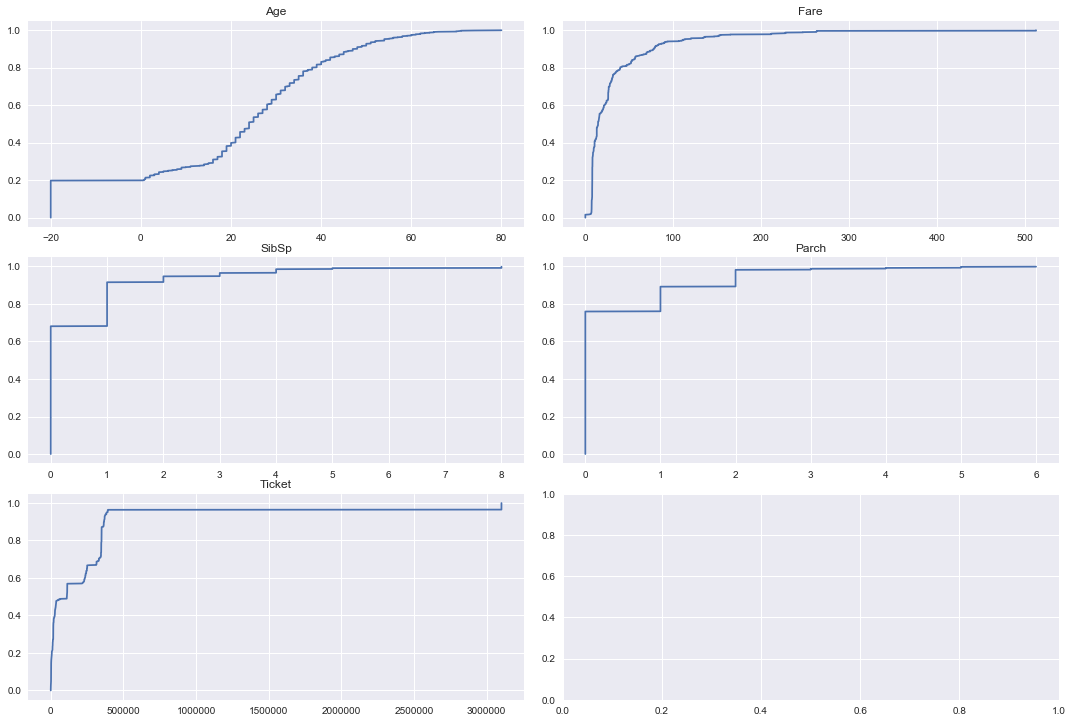

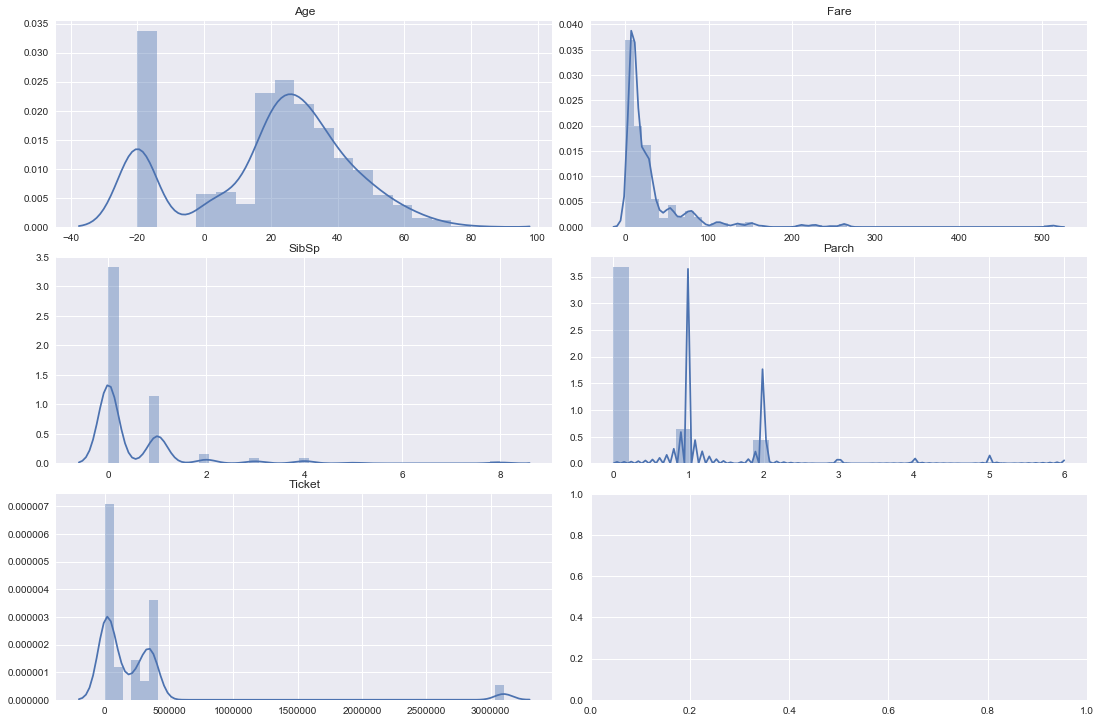

In [100]:
fig, axs = plt.subplots(3,2, figsize=(15,10))
fig.tight_layout()

df_store=df
df=df.fillna(-20)

for ax,i in zip(axs, range(3)):
    for column, j in zip(continuous[2*i:2*(i+1)], range(2)):
        sorted=np.sort(df[column])
        yvals=np.arange(len(sorted))/float(len(sorted))
        ax[j].plot(sorted,yvals)
        ax[j].set_title(column)
    
import seaborn as sns
import statsmodels.api as sm

fig1, axs1 = plt.subplots(3,2, figsize=(15,10))
fig1.tight_layout()

for ax, i in zip(axs1, range(3)):
    for column, j in zip(continuous[2*i:2*(i+1)], range(2)):
        x=df[column].values
        g=sns.distplot(x, norm_hist=True, ax=ax[j])
        g.axes.set_title(column)

df[continuous].describe()


**Simple data exploration continuous variables**
- More data processing needed for ticket and cabin
- A few missing observations for embarked
- Much more males than females

Pclass
Sex
Ticket_str
Cabin
Embarked
Survived


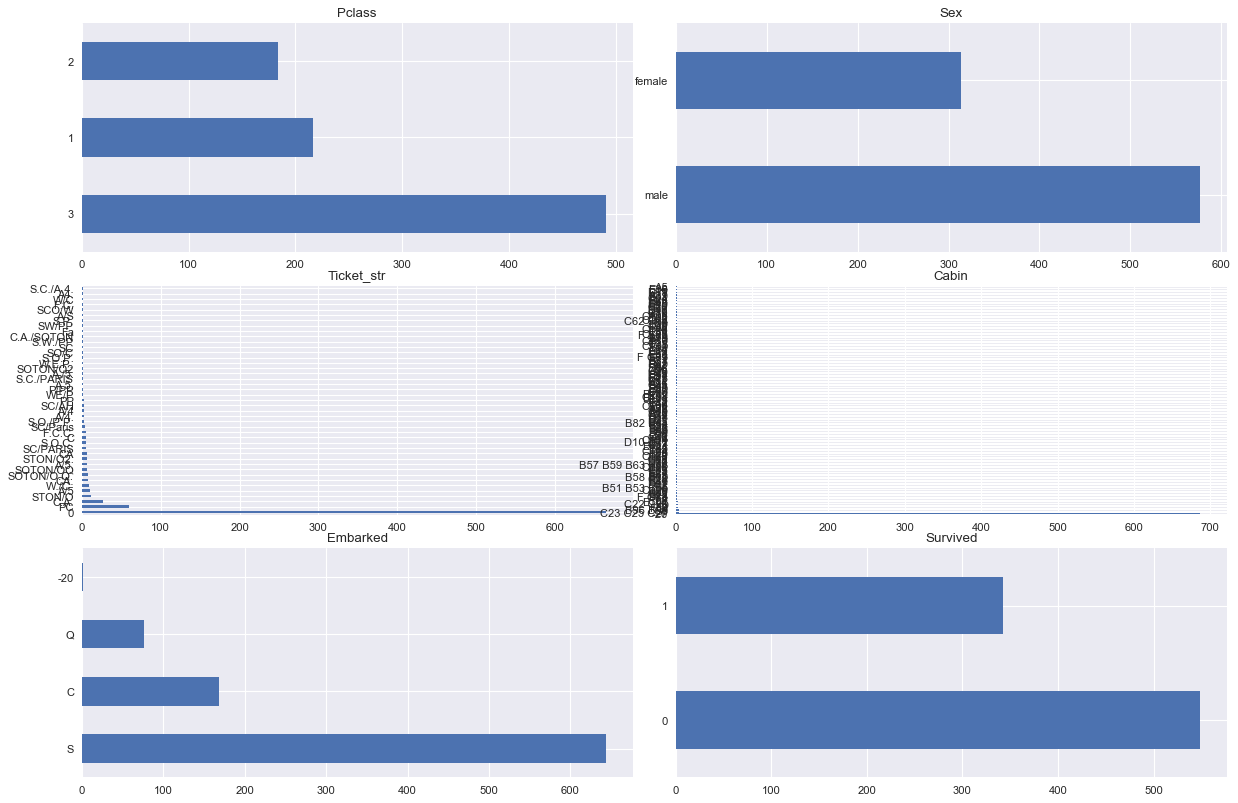

In [103]:
discrete_1=['Pclass', 'Sex', 'Ticket_str', 'Cabin', 'Embarked', 'Survived']

fig1, axs1 = plt.subplots(3,2, figsize=(15,10),dpi=80, squeeze=False)
fig1.tight_layout()
for ax1,n in zip(axs1, range(3)):    
    for i in range(2*n, 2*(n+1)):
        column=discrete_1[i]
        print(column)
        ax1[i%2].set_title(column)
        y=df[column].value_counts()
        y.plot.barh(ax=ax1[i%2])


In [113]:
#print(df['Ticket_str'].value_counts())
#Subset on PC, CA and STON?

#Subset first character, subset <30 or >30.
df['Cabin_letter']=df['Cabin'].str.slice(0,1)
df['Cabin_number']=df['Cabin'].str.slice(1)
print(df['Cabin_number'])

#Subset first character, subset <30 or >30.
ticket_tuples=df['Cabin'].str.split(' ')
subset=pd.Series(ticket_tuples.str[1])
df['Cabin_letter']=subset.str.slice(0,1)
#df['Cabin_number']=subset.str.slice(1,3)
print(df['Cabin_number'])


0             665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
STON/O2.        6
CA              6
SC/PARIS        5
S.O.C.          5
C               5
F.C.C.          5
SC/Paris        4
S.O./P.P.       3
A/4.            3
A/4             3
SC/AH           3
PP              3
WE/P            2
P/PP            2
A.5.            2
S.C./PARIS      2
A./5.           2
SOTON/O2        2
W.E.P.          1
S.O.P.          1
SO/C            1
SC              1
S.W./PP         1
C.A./SOTON      1
Fa              1
SW/PP           1
S.P.            1
A/S             1
SCO/W           1
F.C.            1
W/C             1
A4.             1
S.C./A.4.       1
Name: Ticket_str, dtype: int64
0             NaN
1              85
2             NaN
3             123
4             NaN
5             NaN
6              46
7             NaN
8             NaN
9             NaN
10             